This notebook evaluates the tested coverage and active rates of tested regions with differen extent of overlap with cCREs. This analysis produces key results presented in Supplementary Figure 5. 

In [16]:
# -------------------- Standard Library Imports --------------------
import argparse
import glob
import os
import sys
from multiprocessing import Pool, cpu_count
from random import sample
from subprocess import PIPE, Popen, STDOUT, call, run

# -------------------- Scientific Libraries ------------------------
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pybedtools
import pysam
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# -------------------- PyBedTools Temp Directory -------------------
pybedtools.helpers.set_tempdir('/fs/cbsuhy02/storage/jz855/tmp/') 


In [66]:
# Specify root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)


/local/storage/jz855/STARR_seq_code/Final_Code_Sharing


# Load data

In [67]:
# Load cCRE
data_path = os.path.join(project_root, 'data', 'reference', 'cCRE_v4', 'processed_files', 'K562_cCRE_v4_processed.bed')
ccre_df = pd.read_csv(data_path, sep='\t', header=None)

ccre_df = ccre_df.set_index(3)
ccre_df.head()


,0,1,2,4,5
3,,,,,
EH38E2776516,chr1,10033,10250,Low-DNase,217
EH38E2776517,chr1,10385,10713,Low-DNase,328
EH38E3951272,chr1,16097,16381,Low-DNase,284
EH38E3951273,chr1,17343,17642,Low-DNase,299
EH38E3951274,chr1,29320,29517,Low-DNase,197


In [68]:
# Columns

columns = ['chr', 'start', 'end', 'name', 'logFC', 'strand', 'z_score', 'size', 'call', 
 'forward_raw', 'reverse_raw', 'total_raw', 'forward_signal', 'reverse_signal', 'total_signal', 
 'gro_chr', 'gro_start', 'gro_end', 'gro_type', 'gro_size', 'gro_overlap_bp', 'gro_overlap_pct_region', 'gro_overlap_pct_GROcap_element', 
 'ccre_chr', 'ccre_start', 'ccre_end', 'ccre_name', 'ccre_type', 'ccre_size', 'ccre_overlap_bp', 'ccre_overlap_pct_region', 'ccre_overlap_pct_ccre', 
 'promoter_400bp_tss', 'promoter_1kb_tss', 'promoter_4kb_tss', 
 'separate_GROcap_signal_levels', 'binary_transcription_class', 
 'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements', 
 'CA_CTCF', 'CA_H3K4me3', 'CA_TF', 'dELS', 'pELS', 'Low_DNase', 'PLS', 'CA_only', 'not_overlap_cCRE', 
 'ELS', 'ELS_PLS']

print(len(columns))


52


In [69]:
# Load dataset, orientation-independent calls

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'LentiMPRA', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
lentimpra = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(lentimpra))
lentimpra.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'ATAC_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
atac_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(atac_starr))
atac_starr.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'WHG_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
whg_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(whg_starr))
whg_starr.columns = columns



109468
304921
1622613


# Process data to obtain tested cCREs in different overlap categories in each dataset

In [70]:
def remove_duplicate_ccres(df, ccre_col='ccre_name', region_name_col='name', overlap_col='ccre_overlap_bp'):
    """
    Removes duplicate cCREs from a dataset while keeping:
    - All entries without a cCRE (e.g., ccre_name == '.')
    - One representative entry per cCRE (highest overlap_bp)

    Parameters:
    ----------
    df : pd.DataFrame
        The input dataframe with cCRE annotations.
    ccre_col : str
        Column name indicating the cCRE ID (default: 'ccre_name').
    region_name_col : str
        Column name indicating the unique region name (default: 'name').
    overlap_col : str
        Column name indicating the overlap score to prioritize (default: 'ccre_overlap_bp').

    Returns:
    -------
    pd.DataFrame
        DataFrame with duplicates removed based on cCRE ID.
    """
    print(f"Original entries: {len(df)}")

    # Keep rows without a cCRE assigned
    no_ccre = df[df[ccre_col] == '.']
    print(f"Entries without overlap with cCRE: {len(no_ccre)}")

    # Keep one representative row per cCRE, based on highest overlap
    tested_ccre = df[df[ccre_col] != '.']
    print(f"Entries overap with cCRE: {len(tested_ccre)}")
    print('---')

    tested_ccre = tested_ccre.sort_values(overlap_col, ascending=False)
    tested_ccre = tested_ccre.drop_duplicates(ccre_col)
    print(f"Unique cCREs: {len(tested_ccre)}")
    print(f"Unique tested region names: {len(tested_ccre.drop_duplicates(region_name_col))}")

    # Combine no cCRE and deduplicated tested cCRE entries
    cleaned_df = pd.concat([no_ccre, tested_ccre], ignore_index=True)
    print(f"Final entries after removing cCRE duplicates: {len(cleaned_df)}")

    return cleaned_df



In [71]:
# ------------------------------------------
# Remove duplicate tested cCREs for each assay and report original and cleaned entry counts
# ------------------------------------------

# WHG-STARR-seq
whg_starr_clean = remove_duplicate_ccres(whg_starr)

# ATAC-STARR-seq
atac_starr_clean = remove_duplicate_ccres(atac_starr)

# LentiMPRA
lenti_clean = remove_duplicate_ccres(lentimpra)




Original entries: 1622613
Entries without overlap with cCRE: 713957
Entries overap with cCRE: 908656
---
Unique cCREs: 878217
Unique tested region names: 878217
Final entries after removing cCRE duplicates: 1592174
Original entries: 304921
Entries without overlap with cCRE: 62235
Entries overap with cCRE: 242686
---
Unique cCREs: 222186
Unique tested region names: 222186
Final entries after removing cCRE duplicates: 284421
Original entries: 109468
Entries without overlap with cCRE: 8022
Entries overap with cCRE: 101446
---
Unique cCREs: 99552
Unique tested region names: 99552
Final entries after removing cCRE duplicates: 107574


In [72]:
# Loop through each dataset and assign cCRE overlap category to the ccre_df DataFrame
for data, dataset in zip([whg_starr_clean, atac_starr_clean, lenti_clean], ['WHG_STARR', 'ATAC_STARR', 'LentiMPRA']):

    # Initialize with no overlap
    ccre_df[dataset] = '.'

    # Assign 'Low' if there is at least 1 bp overlap
    low_overlap = data[data['ccre_overlap_bp'] > 0]['ccre_name'].tolist()
    ccre_df.loc[low_overlap, dataset] = 'Low'

    # Assign 'Moderate' if both region and cCRE have ≥50% reciprocal overlap
    moderate_overlap = data[
        (data['ccre_overlap_pct_region'] >= 50) &
        (data['ccre_overlap_pct_ccre'] >= 50)
    ]['ccre_name'].tolist()
    ccre_df.loc[moderate_overlap, dataset] = 'Moderate'

    # Assign 'High' if both region and cCRE have ≥80% reciprocal overlap
    high_overlap = data[
        (data['ccre_overlap_pct_region'] >= 80) &
        (data['ccre_overlap_pct_ccre'] >= 80)
    ]['ccre_name'].tolist()
    ccre_df.loc[high_overlap, dataset] = 'High'

    # Summary of assigned categories
    print(f"{dataset} - Overlap category distribution:")
    print(ccre_df[dataset].value_counts())
    print('-----')


WHG_STARR - Overlap category distribution:
WHG_STARR
.           1470637
Low          684560
Moderate     168620
High          25037
Name: count, dtype: int64
-----
ATAC_STARR - Overlap category distribution:
ATAC_STARR
.           2126668
Low          152820
Moderate      62589
High           6777
Name: count, dtype: int64
-----
LentiMPRA - Overlap category distribution:
LentiMPRA
.           2249302
Moderate      73676
Low           13988
High          11888
Name: count, dtype: int64
-----


In [73]:
ccre_df = ccre_df.reset_index()[[0,1,2,3,4,5, 'WHG_STARR', 'ATAC_STARR', 'LentiMPRA']]

ccre_df.head()


,0,1,2,3,4,5,WHG_STARR,ATAC_STARR,LentiMPRA
0,chr1,10033,10250,EH38E2776516,Low-DNase,217,.,.,.
1,chr1,10385,10713,EH38E2776517,Low-DNase,328,.,.,.
2,chr1,16097,16381,EH38E3951272,Low-DNase,284,.,Moderate,.
3,chr1,17343,17642,EH38E3951273,Low-DNase,299,.,Moderate,.
4,chr1,29320,29517,EH38E3951274,Low-DNase,197,.,Low,.


In [79]:
# ------------------------------------------
# Compute cCRE overlap statistics by cCRE type and dataset
# ------------------------------------------

# Define cCRE categories to analyze
ccre_type = ['dELS', 'pELS', 'PLS', 'CA-H3K4me3', 'CA-CTCF', 'CA-TF', 'CA-only', 'Low-DNase']

# Initialize a list to hold summary DataFrames
stacked_df_list = []

# Iterate through each cCRE type
for ccre in ccre_type:
    
    # Subset the master cCRE DataFrame for the current cCRE type
    df = ccre_df[ccre_df[4] == ccre]
    
    # Loop through each functional genomics dataset
    for dataset in ['WHG_STARR', 'ATAC_STARR', 'LentiMPRA']:
        
        # Subset data by overlap level
        no_overlap      = df[df[dataset] == '.']
        low_overlap     = df[df[dataset] == 'Low']
        moderate_overlap = df[df[dataset] == 'Moderate']
        high_overlap    = df[df[dataset] == 'High']
        have_overlap    = df[df[dataset] != '.']
        
        # Build a DataFrame summarizing counts and percentages
        tmp = pd.DataFrame({
            'cCRE': [f"{ccre}\n({len(df):,})"] * 5,
            'dataset': [dataset] * 5,
            'overlap_type': ['No_overlap', 'Low', 'Moderate', 'High', 'Have_overlap'],
            'count': [
                len(no_overlap), 
                len(low_overlap), 
                len(moderate_overlap), 
                len(high_overlap), 
                len(have_overlap)
            ],
            'total': [len(df)] * 5
        })

        # Compute percentage of each overlap category
        tmp['pct'] = tmp['count'] / tmp['total'] * 100

        # Append to list
        stacked_df_list.append(tmp)

# Concatenate all cCRE-overlap summaries into one DataFrame
stacked_df = pd.concat(stacked_df_list, axis=0, ignore_index=True)

# Output dimensions of the result
print(f"Number of overlap summary entries: {len(stacked_df)}")



Number of overlap summary entries: 120


# Plot tested coverage of cCREs

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns

def stacked_bar_distribution(data, ccre_list, element_order_list, 
                             colormap, label_map, ytick_label_list, 
                             title, out_path=''):
    """
    Plots a horizontal stacked bar chart showing the distribution of overlap types
    across different cCRE categories.

    Parameters:
    - data (pd.DataFrame): DataFrame with columns ['cCRE', 'overlap_type', 'pct'].
    - ccre_list (list of str): Ordered list of cCRE types to plot.
    - element_order_list (list of str): Order of overlap categories to stack (e.g., ['No_overlap', 'Low', 'Moderate', 'High']).
    - colormap (dict): Mapping from overlap types to colors.
    - label_map (dict): Mapping from overlap types to legend labels.
    - ytick_label_list (list of str): Labels to display on the y-axis (e.g., with counts).
    - title (str): Title of the plot.
    - out_path (str): File path to save the figure. If empty, the plot is not saved.
    """

    # Set up plot
    fig, ax = plt.subplots(figsize=(10, 1.2 * len(ccre_list)))
    ax.grid(False)

    # Create y-axis index from top to bottom
    index = list(range(1, len(ccre_list) + 1))
    index.sort(reverse=True)

    bar_width = 0.8
    opacity = 0.8

    # Initialize "left" to zero for the first stack
    left = np.zeros(len(ccre_list))

    # Plot each overlap type as a horizontal bar
    for i, element in enumerate(element_order_list):
        df = data[data['overlap_type'] == element]

        # Extract values to plot
        curr = df['pct'].values

        # Plot the bar
        ax.barh(index, curr, bar_width,
                color=colormap[element],
                align='center',
                alpha=opacity,
                left=left)

        # Update left position for next stack
        left += curr

    # Axis labels and limits
    ax.set_xlabel('Percentage', fontsize=18)
    ax.set_xlim([0, 100])
    ax.set_ylabel('')
    ax.set_ylim([0.5, len(ccre_list) + 0.5])

    # Y-axis ticks and labels
    ax.set_yticks(index)
    ax.set_yticklabels(ytick_label_list, fontsize=17)

    # Format x-axis tick labels with percentage signs
    xticks = ax.get_xticks()
    ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)

    # Remove top/right spines
    sns.despine()

    # Add legend
    legend_handles = [mpatches.Patch(color=colormap[e], label=label_map[e]) for e in element_order_list]
    ax.legend(handles=legend_handles,
              bbox_to_anchor=(0.5, -0.1),
              loc='upper center',
              ncol=2,
              fancybox=True,
              fontsize=17)

    # Set plot title
    ax.set_title(title, fontsize=20)

    # Save figure if path provided
    if out_path:
        plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)

    

In [109]:
# ------------------------------------------
# Set plot parameters for stacked bar visualization
# ------------------------------------------

# Define the order of overlap categories for plotting
element_order_list = ['High', 'Moderate', 'Low', 'No_overlap']

# Define color palette for each overlap category
palette = {
    'No_overlap': '#f0f9e8',
    'Low': '#EBD3A9',
    'Moderate': '#EDB699',
    'High': '#FF8685'
}

# Define label mapping for legend entries
label_map = {
    'No_overlap': 'Not Tested',
    'Low': 'Rest of Overlap',
    'Moderate': '50% - 80% Reciprocal Overlap',
    'High': u'$\geq$ 80% Reciprocal Overlap'
}

# ------------------------------------------
# Extract unique y-axis labels (formatted cCRE names)
# ------------------------------------------

ytick_label_list = []
seen = set()

# Collect the first appearance of each cCRE name (with count annotation)
for idx in stacked_df.index:
    ccre_label = stacked_df.loc[idx, 'cCRE']
    if ccre_label not in seen:
        ytick_label_list.append(ccre_label)
        seen.add(ccre_label)

# Display all extracted y-axis labels
print("Full ytick_label_list:")
print(ytick_label_list)

# Limit to only the first three cCRE types for focused plotting
els_pls_label_list = ytick_label_list[:3]
print("dELS, pELS, and PLS:")
print(els_pls_label_list)


Full ytick_label_list:
['dELS\n(35,488)', 'pELS\n(41,813)', 'PLS\n(20,041)', 'CA-H3K4me3\n(5,861)', 'CA-CTCF\n(28,271)', 'CA-TF\n(38,859)', 'CA-only\n(2,958)', 'Low-DNase\n(2,175,563)']
dELS, pELS, and PLS:
['dELS\n(35,488)', 'pELS\n(41,813)', 'PLS\n(20,041)']


## WHG-STARR-seq

<ipython-input-108-f3419ef111d2>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)


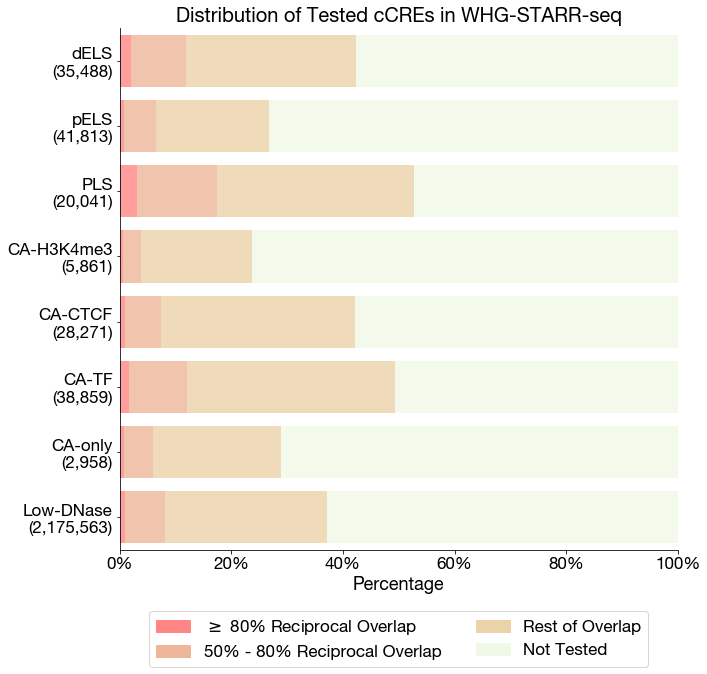

In [110]:
# ------------------------------------------
# Plot stacked bar chart showing distribution of tested cCREs in WHG-STARR-seq
# ------------------------------------------

# Filter the dataset to only include WHG-STARR-seq data
whg_starr_plot_df = stacked_df[stacked_df['dataset'] == 'WHG_STARR']

# Call the custom plotting function to generate the figure
stacked_bar_distribution(
    data=whg_starr_plot_df,
    ccre_list=ccre_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    title='Distribution of Tested cCREs in WHG-STARR-seq'
)

## ATAC-STARR-seq

<ipython-input-108-f3419ef111d2>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)


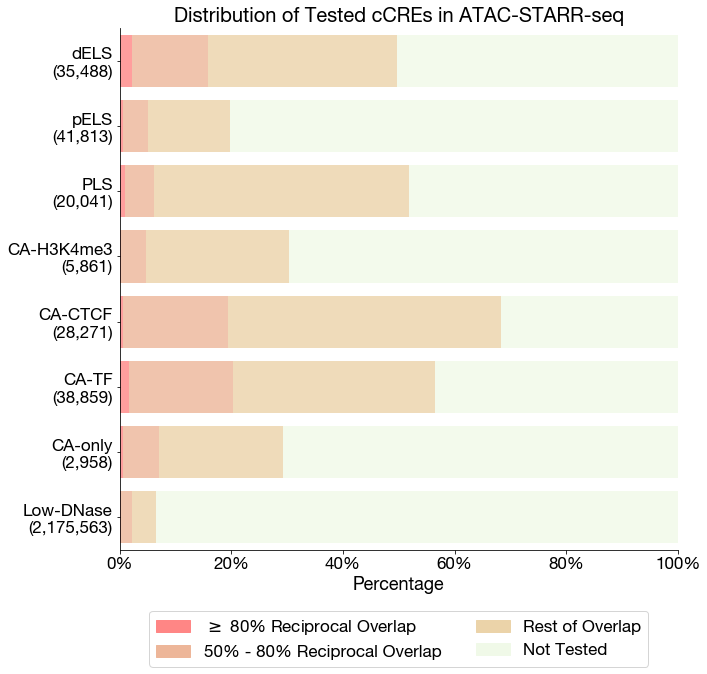

In [111]:
# ------------------------------------------
# Plot stacked bar chart showing distribution of tested cCREs in ATAC-STARR-seq
# ------------------------------------------

# Filter the dataset to only include ATAC-STARR-seq data
atac_starr_plot_df = stacked_df[stacked_df['dataset'] == 'ATAC_STARR']

# Call the custom plotting function to generate the figure
stacked_bar_distribution(
    data=atac_starr_plot_df,
    ccre_list=ccre_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    title='Distribution of Tested cCREs in ATAC-STARR-seq'
)


## LentiMPRA

<ipython-input-108-f3419ef111d2>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(x)}%' for x in xticks], fontsize=17)


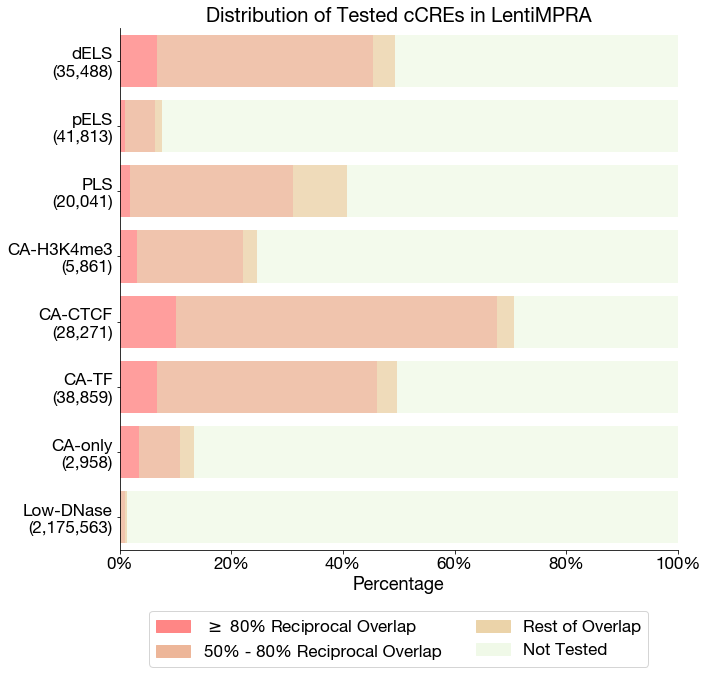

In [112]:
# ------------------------------------------
# Plot stacked bar chart showing distribution of tested cCREs in LentiMPRA
# ------------------------------------------

# Filter the dataset to only include ATAC-STARR-seq data
lenti_plot_df = stacked_df[stacked_df['dataset'] == 'LentiMPRA']

# Call the custom plotting function to generate the figure
stacked_bar_distribution(
    data=lenti_plot_df,
    ccre_list=ccre_type,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=ytick_label_list,
    title='Distribution of Tested cCREs in LentiMPRA'
)


## Plot tested coverage statistics specifically for dELS, pELS, and PLS for the three datasets together

In [113]:
def stacked_bar_subplot(ax, data, ccre_list, element_order_list, 
                        colormap, label_map, ytick_label_list, 
                        ylabel, hide_xaxis=False, legend=False):
    """
    Plots a horizontal stacked bar chart on a provided matplotlib Axes object.

    Parameters:
    - ax (matplotlib.axes.Axes): Axes object to plot the stacked bar chart on.
    - data (pd.DataFrame): DataFrame with columns ['cCRE', 'overlap_type', 'pct'] representing each stacked bar segment.
    - ccre_list (list of str): List of cCRE types to plot.
    - element_order_list (list of str): Order in which overlap types should be stacked.
    - colormap (dict): Mapping from overlap_type to color.
    - label_map (dict): Mapping from overlap_type to legend label.
    - ytick_label_list (list of str): Labels for the y-axis (one per cCRE).
    - ylabel (str): Label for the y-axis.
    - hide_xaxis (bool): Whether to hide the x-axis labels and ticks.
    - legend (bool): Whether to include a legend.
    """
    
    # Disable grid for cleaner visualization
    ax.grid(False)
    
    # Create reversed y-axis positions for top-down bar stacking
    index = list(range(1, len(ccre_list)+1))[::-1]
    bar_width = 0.8
    opacity = 0.8

    # Stack each overlap_type as horizontal bar segments
    for i, element in enumerate(element_order_list):
        df = data[data['overlap_type'] == element]
        if i == 0:
            # Initialize left edge for each bar
            left = np.zeros(len(set(df['cCRE'].tolist())))
        curr = df['pct'].values  # Segment width (percentage)
        ax.barh(index, curr, bar_width, color=colormap[element], 
                align='center', alpha=opacity, left=left)
        left += curr  # Update left edge for the next segment

    # Set axis labels and ticks
    ax.set_ylabel(ylabel, fontsize=17)
    ax.set_xlim([0, 100])
    ax.set_yticks(index)
    ax.set_yticklabels(ytick_label_list, rotation=0, fontsize=15)
    ax.set_ylim([0.5, len(ccre_list) + 0.5])

    # Configure x-axis appearance based on input flag
    if hide_xaxis:
        ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
        ax.minorticks_off()
        ax.set_xlabel('', fontsize=20)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
    else:
        # Format x-axis ticks as percentages
        xticks = ax.get_xticks()
        ax.set_xticklabels([f"{int(round(x))}%" for x in xticks], fontsize=15)
        ax.set_xlabel('Percentage', fontsize=17)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    # Create and show legend if specified
    if legend:
        legend_handles = [
            mpatches.Patch(color=colormap[e], label=label_map[e])
            for e in element_order_list
        ]
        plt.legend(handles=legend_handles, bbox_to_anchor=(0.5, -0.3), loc='upper center', 
                   fancybox=True, ncol=2, fontsize=17)
        

LentiMPRA entries: 15
ATAC-STARR-seq entries: 15
WHG-STARR-seq entries: 15


<ipython-input-113-ef9af7a4a13e>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{int(round(x))}%" for x in xticks], fontsize=15)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


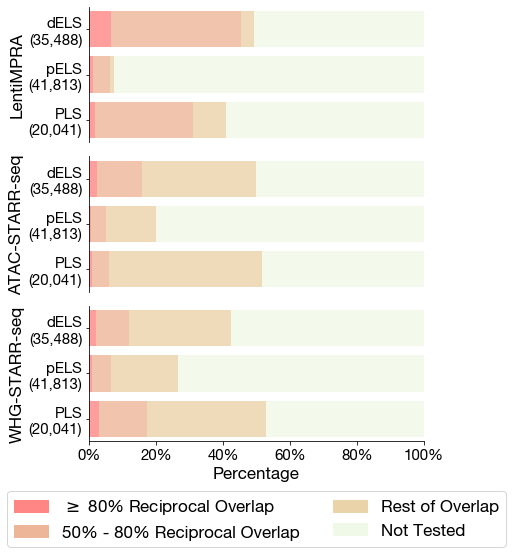

In [114]:
# ------------------------------------------
# Create stacked bar subplot for 3 assays and selected cCREs
# ------------------------------------------

ccre_subtype = ['dELS', 'pELS', 'PLS']

# Set up figure and layout
fig = plt.figure(figsize=(6, 8))
plt.subplots_adjust(hspace=0.1)  # Adjust vertical space between subplots
row = 0  # Start row index

# ----------------------------
# LentiMPRA
# ----------------------------
ax = plt.subplot2grid((3, 1), (row, 0), rowspan=1)
tmp = lenti_plot_df[lenti_plot_df['cCRE'].isin(els_pls_label_list)]
print(f"LentiMPRA entries: {len(tmp)}")

ax = stacked_bar_subplot(
    ax=ax,
    data=tmp,
    ccre_list=ccre_subtype,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=els_pls_label_list,
    ylabel='LentiMPRA',
    hide_xaxis=True,
    legend=False
)
row += 1

# ----------------------------
# ATAC-STARR-seq
# ----------------------------
ax = plt.subplot2grid((3, 1), (row, 0), rowspan=1, sharex=ax)
tmp = atac_starr_plot_df[atac_starr_plot_df['cCRE'].isin(els_pls_label_list)]
print(f"ATAC-STARR-seq entries: {len(tmp)}")

ax = stacked_bar_subplot(
    ax=ax,
    data=tmp,
    ccre_list=ccre_subtype,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=els_pls_label_list,
    ylabel='ATAC-STARR-seq',
    hide_xaxis=True,
    legend=False
)
row += 1

# ----------------------------
# WHG-STARR-seq
# ----------------------------
ax = plt.subplot2grid((3, 1), (row, 0), rowspan=1, sharex=ax)
tmp = whg_starr_plot_df[whg_starr_plot_df['cCRE'].isin(els_pls_label_list)]
print(f"WHG-STARR-seq entries: {len(tmp)}")

ax = stacked_bar_subplot(
    ax=ax,
    data=tmp,
    ccre_list=ccre_subtype,
    element_order_list=element_order_list,
    colormap=palette,
    label_map=label_map,
    ytick_label_list=els_pls_label_list,
    ylabel='WHG-STARR-seq',
    hide_xaxis=False,
    legend=True  # Only show legend for last plot
)

# Save the figure
out_path = os.path.join(project_root, 'plot', 'active_rate', 'dELS_pELS_PLS_tested_coverage_three_assays.pdf')
if(out_path != ''):
    plt.savefig(
        out_path,
        bbox_inches='tight',
        transparent=True,
        dpi=300
    )
    

# Assess active rate of each type of cCREs in different overlap category

In [89]:
def compute_active_rate_summary(df):
    """
    Compute active/inactive region counts and active rate from a DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        Subset DataFrame of tested regions with a 'call' column.

    Returns:
    -------
    Tuple[int, int, int, float]
        - num_active: Number of active regions
        - num_inactive: Number of inactive regions
        - num_total: Total number of regions
        - active_rate: Percentage of active regions among total (0–100)
    """
    num_total = len(df)

    if num_total > 0:
        num_active = len(df[df['call'] == 'active'])
        num_inactive = len(df[df['call'] == 'inactive'])
        active_rate = num_active / num_total * 100
    else:
        num_active = 0
        num_inactive = 0
        active_rate = 0.0

    return num_active, num_inactive, num_total, active_rate


def calculate_active_region_stats(data, category_col, category_value):
    """
    Calculate activity statistics (active, inactive, and total counts) for a specific category.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing a 'call' column indicating whether a region is 'active' or 'inactive',
        along with a categorical column to group by (e.g., 'promoter_1kb_tss', 'divergent', etc.).

    category_col : str
        The name of the column containing category labels to subset the data.

    category_value : str
        The specific category value within `category_col` to calculate statistics for.

    Returns:
    --------
    tuple : (int, int, int, float)
        - Number of active regions
        - Number of inactive regions
        - Total number of regions
        - Percentage of active regions (0–100%)
    """

    subset = data[data[category_col] == category_value]
    return compute_active_rate_summary(subset)


def format_annotation_text(row):
    """
    Format text annotation for active rate display.

    Given a row from a DataFrame that includes the number of active and total regions,
    this function returns a string in the format:
        "X,XXX/Y,YYY (Z%)"
    where:
        - X,XXX is the number of active regions (with comma formatting)
        - Y,YYY is the total number of regions (with comma formatting)
        - Z% is the active rate percentage, rounded to:
            - 1 decimal place if < 1%
            - nearest integer if ≥ 1%

    Parameters:
    -----------
    row : pd.Series
        A row from a DataFrame containing 'num_active', 'num_total', and 'active_rate' columns.

    Returns:
    --------
    str
        Formatted string annotation.
    """
    # Extract values from the row
    active = row['num_active']
    total = row['num_total']
    rate = row['active_rate']

    # Format percentage: 1 decimal if <1%, otherwise round to whole number
    if rate < 1:
        percent_str = f"{rate:.1f}%"
    else:
        percent_str = f"{round(rate):.0f}%"

    # Format string: "X,XXX/Y,YYY (Z%)"
    return f"{active:,}/{total:,} ({percent_str})"


In [ ]:
# --------------------------------------------------------------
# Analyze Active Rates Across cCRE Types and Overlap Categories
# --------------------------------------------------------------

# Define cCRE categories and overlap classifications
cCRE_type_col_list = [
    'dELS', 'pELS', 'PLS', 'CA_H3K4me3', 'CA_CTCF', 
    'CA_TF', 'CA_only', 'Low_DNase', 'not_overlap_cCRE'
]
overlap_class_list = ['low', 'moderate', 'high']

# Container to hold active region stats across all datasets
all_stats_by_dataset = []

# Loop over each dataset and label
for dataset_df, dataset_name in zip(
    [whg_starr_clean, atac_starr_clean, lenti_clean], 
    ['WHG-STARR-seq', 'ATAC-STARR-seq', 'LentiMPRA']
):
    dataset_stats_rows = []

    for cCRE_col in cCRE_type_col_list:
        
        if cCRE_col == 'not_overlap_cCRE':
            # Handle regions that do not overlap with any cCRE
            num_active, num_inactive, num_total, active_rate = calculate_active_region_stats(
                dataset_df, cCRE_col, 'not_overlap_cCRE'
            )
            dataset_stats_rows.append((
                dataset_name, cCRE_col, 'not_overlap_cCRE',
                num_active, num_inactive, num_total, active_rate
            ))
            continue
        
        # Loop through overlap classifications for cCREs
        for overlap_class in overlap_class_list:
            num_active, num_inactive, num_total, active_rate = calculate_active_region_stats(
                dataset_df, cCRE_col, overlap_class
            )
            dataset_stats_rows.append((
                dataset_name, cCRE_col, overlap_class,
                num_active, num_inactive, num_total, active_rate
            ))

    # Create a DataFrame of the stats for the current dataset
    dataset_stats_df = pd.DataFrame(
        dataset_stats_rows,
        columns=[
            'dataset', 'category_col', 'category_value',
            'num_active', 'num_inactive', 'num_total', 'active_rate'
        ]
    )
    
    all_stats_by_dataset.append(dataset_stats_df)

# Concatenate results across all datasets into one DataFrame
combined_stats_df = pd.concat(all_stats_by_dataset, axis=0, ignore_index=True)

# --------------------------------------------------------------
# Format annotation text as "active/total (X%)"
# Adds thousands separators and rounds percentages:
#   - one decimal if <1%, else no decimals
# --------------------------------------------------------------
combined_stats_df['text'] = combined_stats_df.apply(format_annotation_text, axis=1)

# Uncomment below to preview final results
# print(combined_stats_df.head())


In [ ]:
# ---------------------------------------------------------
# Function: barplot_subplot_sharex
# Description:
#   Draws a grouped barplot using seaborn with optional axis sharing.
#   Also annotates each bar with custom text values (e.g., percentages).
#
# Parameters:
#   - ax: matplotlib Axes object for plotting
#   - data: DataFrame containing the plotting data
#   - x, y: column names for x-axis and y-axis values
#   - hue: column name for categorical grouping
#   - hue_order: list defining order of hue categories
#   - x_order: list defining order of x-axis categories
#   - palette: dict mapping hue values to color codes
#   - xlabel, ylabel: axis labels
#   - xticklabel: custom x-axis tick labels
#   - legend: whether to show legend
#   - hide_xaxis: whether to hide x-axis (for subplots)
# ---------------------------------------------------------

def barplot_subplot_sharex(ax, data, x, y, hue, hue_order, 
                           x_order, palette, xlabel, ylabel, 
                           xticklabel, legend=False, hide_xaxis=False):

    # Draw grouped barplot without error bars
    sns.barplot(
        data=data, x=x, y=y, hue=hue, ax=ax,
        hue_order=hue_order, order=x_order, 
        width=0.8, errorbar=None, palette=palette, legend=legend
    )
    
    # Format y-axis: percentage with '%' sign
    ax.set_ylim([0, 100])
    ytick_vals = ax.get_yticks().tolist()
    ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
    ax.set_ylabel(ylabel, fontsize=20)
    
    # Prepare annotation text for each bar from the "text" column
    labels = []
    for h_val in hue_order:
        for x_val in x_order:
            tmp = data[(data[x] == x_val) & (data[hue] == h_val)]
            label = tmp['text'].tolist()[0] if not tmp.empty else ''
            labels.append(label)

    # Add annotation text on top of each bar
    for bar, label in zip(ax.patches, labels):
        ax.text(
            bar.get_x() + bar.get_width() / 2, 100, label,
            ha='center', va='top', rotation=90, fontsize=15
        )
    
    # Format x-axis
    if hide_xaxis:
        ax.xaxis.set_tick_params(left=False, labelleft=False)
        ax.minorticks_off()
        ax.set_xlabel('', fontsize=20)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
    else:
        ax.set_xticklabels(xticklabel, fontsize=15, rotation=30)
        ax.set_xlabel(xlabel, fontsize=17)
        sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    # Optional legend
    if legend:
        handles = [
            mpatches.Patch(color=palette['high'], label='High'),
            mpatches.Patch(color=palette['moderate'], label='Moderate'),
            mpatches.Patch(color=palette['low'], label='Low')
        ]
        ax.legend(
            handles=handles,
            bbox_to_anchor=(0.95, -0.4),
            fancybox=True,
            borderaxespad=0.0,
            fontsize=17,
            ncol=3
        )


<ipython-input-97-b7f19ed6ffab>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-97-b7f19ed6ffab>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-97-b7f19ed6ffab>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-97-b7f19ed6ffab>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabel, fontsize=15, rotation=30)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


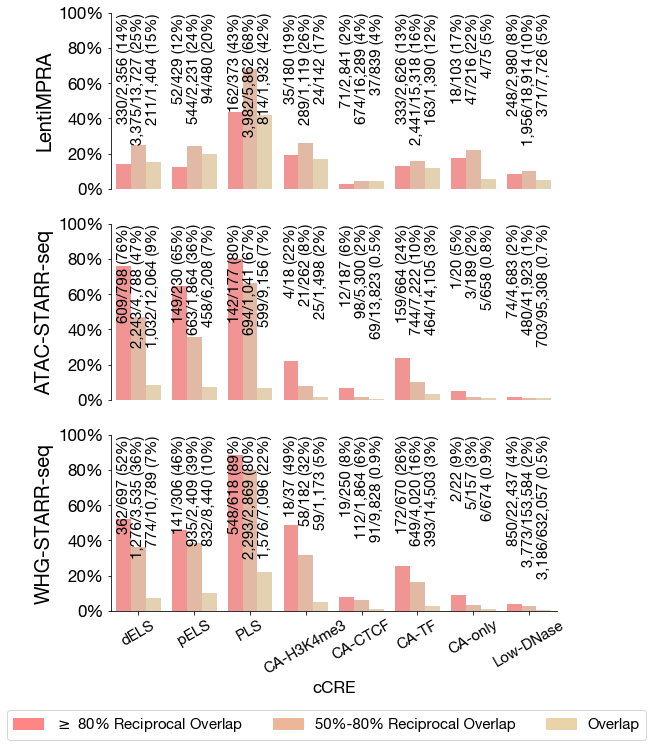

In [115]:
# -----------------------------------------------
# Plot Active Rates Across cCRE Types in 3 Assays
# -----------------------------------------------

# Define key plotting parameters
x = 'category_col'  # X-axis: cCRE category
y = 'active_rate'    # Y-axis: percentage of active elements
hue = 'category_value'     # Hue: overlap class
hue_order = ['high', 'moderate', 'low']  # Overlap categories
x_order = ['dELS', 'pELS', 'PLS', 
           'CA_H3K4me3', 'CA_CTCF', 'CA_TF', 'CA_only', 
           'Low_DNase']  # Internal variable names
xtick_labels = ['dELS', 'pELS', 'PLS', 
                'CA-H3K4me3', 'CA-CTCF', 'CA-TF', 'CA-only', 
                'Low-DNase']  # Displayed x-axis labels

# Color mapping for different overlap classes
palette = {
    'high': '#FF8685',        # ≥80% reciprocal overlap
    'moderate': '#EDB699',    # 50–80% reciprocal overlap
    'low': '#EBD3A9',         # Other overlap
    'None': '#f0f9e8'         # Not used here but kept for consistency
}

category_type = 'cCRE'  # Used in output filename

# Initialize figure
fig = plt.figure(figsize=(8, 11))
plt.subplots_adjust(hspace=0.2)

# -----------------------
# LentiMPRA Subplot
# -----------------------
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'LentiMPRA') & 
                              (combined_stats_df['category_col'] != 'not_cCRE')]
barplot_subplot_sharex(
    ax=ax1, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='LentiMPRA',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# -----------------------
# ATAC-STARR-seq Subplot
# -----------------------
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'ATAC-STARR-seq') & 
                              (combined_stats_df['category_col'] != 'not_cCRE')]
barplot_subplot_sharex(
    ax=ax2, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='ATAC-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# -----------------------
# WHG-STARR-seq Subplot
# -----------------------
ax3 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
plot_data = combined_stats_df[(combined_stats_df['dataset'] == 'WHG-STARR-seq') & 
                              (combined_stats_df['category_col'] != 'not_cCRE')]
barplot_subplot_sharex(
    ax=ax3, data=plot_data, x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order, palette=palette,
    xlabel=category_type, ylabel='WHG-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=False
)

# -----------------------
# Legend (Global for Figure)
# -----------------------
legend_handles = [
    mpatches.Patch(color=palette['high'], label=u'$\geq$ 80% Reciprocal Overlap'),
    mpatches.Patch(color=palette['moderate'], label='50%-80% Reciprocal Overlap'),
    mpatches.Patch(color=palette['low'], label='Overlap')
]
fig.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.5, 0.00), loc='upper center',
    fancybox=True, borderaxespad=0., fontsize=15, ncol=3
)

# -----------------------
# Save Plot
# -----------------------
out_path = os.path.join(project_root, 'plot', 'active_rate', 'active_rate_of_all_types_cCRE.pdf')
if(out_path != ''):
    plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)


In [104]:
# not overlap with any cCREs

no_overlap_stats_df = combined_stats_df[combined_stats_df['category_col'] == 'not_overlap_cCRE']

no_overlap_stats_df


,dataset,category_col,category_value,num_active,num_inactive,num_total,active_rate,text
24,WHG-STARR-seq,not_overlap_cCRE,not_overlap_cCRE,2932,711025,713957,0.410669,"2,932/713,957 (0.4%)"
49,ATAC-STARR-seq,not_overlap_cCRE,not_overlap_cCRE,341,61894,62235,0.547923,"341/62,235 (0.5%)"
74,LentiMPRA,not_overlap_cCRE,not_overlap_cCRE,178,7844,8022,2.218898,"178/8,022 (2%)"


<ipython-input-97-b7f19ed6ffab>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-97-b7f19ed6ffab>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-97-b7f19ed6ffab>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{round(v)}%" for v in ytick_vals], fontsize=17)
<ipython-input-97-b7f19ed6ffab>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabel, fontsize=15, rotation=30)
feat NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


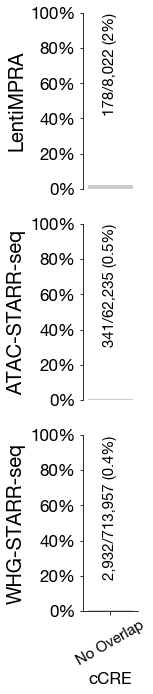

In [117]:
# -------------------------------------------------------
# Plot Active Rates for non-cCRE Regions in 3 Assays
# -------------------------------------------------------

# Define plot variables
x = 'category_value'         # X-axis: grouping variable
y = 'active_rate'           # Y-axis: percentage of active regions
hue_order = ['not_overlap_cCRE']    # Single bar category
x_order = ['not_overlap_cCRE']      # Only one x category: non-cCRE regions
xtick_labels = ['No Overlap']

# Color palette
palette = {
    'High': '#FF8685',        # For legend consistency
    'Moderate': '#EDB699',
    'Low': '#EBD3A9',
    'None': '#f0f9e8',
    'not_overlap_cCRE': '#cccccc'     # Color for the non-cCRE bar
}

# Define label for plot group
category_type = 'cCRE'

# Initialize figure and layout
fig = plt.figure(figsize=(1, 11))
plt.subplots_adjust(hspace=0.2)

# ------------------------------------------
# LentiMPRA subplot
# ------------------------------------------
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
plot_data = no_overlap_stats_df[(no_overlap_stats_df['dataset'] == 'LentiMPRA')]

barplot_subplot_sharex(
    ax=ax1, data=plot_data,
    x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order,
    palette=palette,
    xlabel=category_type, ylabel='LentiMPRA',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# ------------------------------------------
# ATAC-STARR-seq subplot
# ------------------------------------------
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=1)
plot_data = no_overlap_stats_df[(no_overlap_stats_df['dataset'] == 'ATAC-STARR-seq')]

barplot_subplot_sharex(
    ax=ax2, data=plot_data,
    x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order,
    palette=palette,
    xlabel=category_type, ylabel='ATAC-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=True
)

# ------------------------------------------
# WHG-STARR-seq subplot
# ------------------------------------------
ax3 = plt.subplot2grid((3, 1), (2, 0), rowspan=1)
plot_data = no_overlap_stats_df[(no_overlap_stats_df['dataset'] == 'WHG-STARR-seq')]

barplot_subplot_sharex(
    ax=ax3, data=plot_data,
    x=x, y=y,
    hue=hue, hue_order=hue_order,
    x_order=x_order,
    palette=palette,
    xlabel=category_type, ylabel='WHG-STARR-seq',
    xticklabel=xtick_labels,
    legend=False, hide_xaxis=False
)


# ------------------------------------------
# Save figure to PDF
# ------------------------------------------
out_path = os.path.join(project_root, 'plot', 'active_rate', 'active_rate_of_regions_not_overlap_with_cCRE.pdf')
if out_path:
    plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)
